In [1]:
import deepxde as dde
import numpy as np

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


In [37]:
geom = dde.geometry.Interval(0, 1)

In [51]:
P = 80
E = 2*(10^11)
L = 1
b = 0.2
I = 0.2*(L^3)/12

d1 = (P/E*I)

print(I)
print(d1)


0.03333333333333333
1.3333333333333333


In [52]:
def ddy(x, y):
    return dde.grad.hessian(y, x)


def dddy(x, y):
    return dde.grad.jacobian(ddy(x, y), x)

In [53]:
def pde(x,y):
    dy_xx = ddy(x,y)
    dy_xxxx = dde.grad.hessian(dy_xx, x)
    return dy_xxxx + d1

In [54]:
def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0],0)

In [55]:
def boundary_r(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)

In [63]:
def func(x):
    return (-(x ** 4) / 24 + x ** 3 / 6 - x ** 2 / 4)*d1

In [64]:
bc1 = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_l)
bc2 = dde.icbc.NeumannBC(geom, lambda x: 0, boundary_l)

In [65]:
bc3 = dde.icbc.OperatorBC(geom, lambda x,y, _: ddy(x,y), boundary_r)
bc4 = dde.icbc.OperatorBC(geom, lambda x,y, _: dddy(x,y), boundary_r)

In [66]:
data = dde.data.PDE(
    geom,
    pde,
    [bc1, bc2, bc3, bc4],
    num_domain = 10,
    num_boundary = 2,
    solution = func,
    num_test = 100,
)

In [67]:
layer_size = [1] + [20]*3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

In [68]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.315168 s

'compile' took 9.048233 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [2.04e+00, 0.00e+00, 1.31e-02, 8.04e-04, 8.37e-04]    [2.07e+00, 0.00e+00, 1.31e-02, 8.04e-04, 8.37e-04]    [2.19e-01]    
1000      [3.38e-04, 1.01e-09, 6.23e-07, 4.37e-06, 1.25e-06]    [2.82e-04, 1.01e-09, 6.23e-07, 4.37e-06, 1.25e-06]    [2.98e-03]    
2000      [1.47e-04, 2.35e-09, 2.27e-08, 3.40e-07, 1.62e-08]    [1.67e-04, 2.35e-09, 2.27e-08, 3.40e-07, 1.62e-08]    [9.83e-04]    
3000      [8.42e-05, 8.87e-10, 5.82e-09, 9.87e-08, 3.77e-09]    [9.93e-05, 8.87e-10, 5.82e-09, 9.87e-08, 3.77e-09]    [1.28e-03]    
4000      [5.13e-05, 3.14e-11, 1.00e-08, 3.89e-08, 3.00e-12]    [6.24e-05, 3.14e-11, 1.00e-08, 3.89e-08, 3.00e-12]    [1.06e-03]    
5000      [4.66e-05, 1.22e-07, 9.32e-08, 2.29e-09, 4.64e-07]    [4.83e-0

Saving loss history to C:\Users\ok\Downloads\DL\loss.dat ...
Saving training data to C:\Users\ok\Downloads\DL\train.dat ...
Saving test data to C:\Users\ok\Downloads\DL\test.dat ...


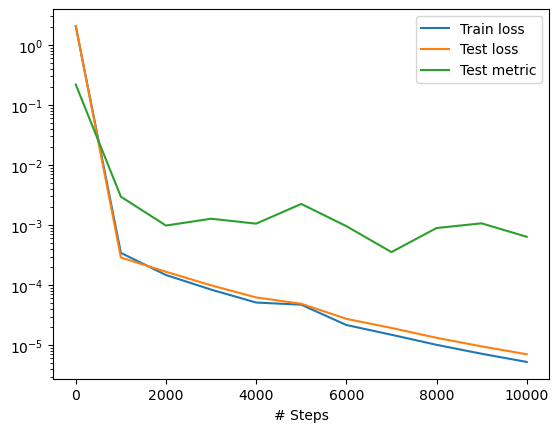

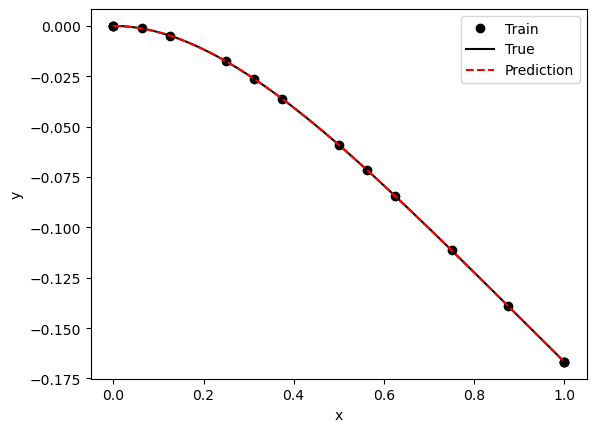

In [69]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)